# Classification

In this notebook, classifiers are trained to be able to find optimal base level algorithm per user.
Random Forest classifier is used for classification.
Binary Particle Swarm Optimization is used to find optimal subsets of base level algorithms and features used.

This notebook is structured as follows:

    1 Using complete sets of recommender algorithms and features
    2 Searching for optimal subsets of base level algorithms (classes) and features
        2.1 Configuration #1
            2.1.1 BPSO
            2.1.2 Hyperparameter tuning for optimal subsets
        2.2 Configuration #2
            2.2.1 BPSO
            2.2.2 Hyperparameter tuning for optimal subsets
        2.3 Configuration #3
            2.3.1 BPSO
            2.3.2 Hyperparameter tuning for optimal subsets
        2.4 Configuration #4
            2.4.1 BPSO
            2.4.2 Hyperparameter tuning for optimal subsets
        2.5 Configuration #5
            2.5.1 BPSO
            2.5.2 Hyperparameter tuning for optimal subsets
        2.6 Configuration #6
            2.6.1 BPSO
            2.6.2 Hyperparameter tuning for optimal subsets
        2.7 Configuration #7 - cross-validation replaced by random search with cross-validation
            2.7.1 BPSO
            2.7.2 Hyperparameter tuning for optimal subsets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 5]

In [3]:
DATA_PATH = 'data/fstore/'
METRICS = ['NDCG@100', 'RR@100', 'P@10', 'R@10']
NUM_THREADS = 8
CV_FOLDS = 5
RS_ITERATIONS = 150
RAND_STATE = 1739
TEST_SIZE = 0.8

In [4]:
# load users with existing optimal rs algorithm and their features
data = pd.read_csv(DATA_PATH+'meta/data.csv')
data.head()

,user_id,class,unique_items,users_sharing_1,users_sharing_1+,users_sharing_10%+,users_sharing_2,users_sharing_2+,users_sharing_20%+,users_sharing_3,...,ds_category4_top_count_normalized,ds_category_last_nunique,ds_category_last_top_count,ds_category_last_top_count_normalized,ds_gender_nunique,ds_gender_top_count,ds_gender_top_count_normalized,ds_color_nunique,ds_color_top_count,ds_color_top_count_normalized
0,2,popular,6,994,1071,1071,74,77,77,3,...,1.000000,2.0,5.0,0.833333,1.0,6.0,1.0,4.0,3.0,0.500000
1,3,itemknn,38,11984,16060,393,2839,4076,4,844,...,0.368421,4.0,14.0,0.368421,1.0,38.0,1.0,11.0,12.0,0.315789
2,4,bpr,3,550,566,566,16,16,566,0,...,1.000000,1.0,3.0,1.000000,1.0,3.0,1.0,3.0,1.0,0.333333
3,7,als,1,1146,1146,1146,0,0,1146,0,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000
4,9,als,28,6505,7422,139,778,917,1,117,...,0.464286,6.0,13.0,0.464286,1.0,28.0,1.0,13.0,5.0,0.178571


In [5]:
# load all users rs performance evaluations
all_users_performance = pd.read_csv(DATA_PATH+'rs_performance.csv')
for m in METRICS:
    all_users_performance[m] = all_users_performance[m].apply(literal_eval)
all_users_performance.head()

,NDCG@100,P@10,R@10,RR@100,user_id
0,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",0
1,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",1
2,"[[0.056316753775798256, popular], [0.054120274...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.015625, popular], [0.013157894736842105, b...",2
3,"[[0.06435448568843775, itemknn], [0.0630680314...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.015151515151515152, itemknn], [0.013888888...",3
4,"[[0.412416442009166, bpr], [0.2353703166846384...","[[0.2, bpr], [0.1, itemknn], [0.1, als], [0.0,...","[[0.16666666666666666, bpr], [0.08333333333333...","[[0.3333333333333333, als], [0.2, bpr], [0.142...",4


In [6]:
# join datasets
data = pd.merge(all_users_performance, data, on='user_id', how='left')

In [7]:
# split data to train and test sets of users
train_all, test_all = train_test_split(data, random_state=RAND_STATE, train_size=1-TEST_SIZE, test_size=TEST_SIZE)
train = train_all.dropna(axis=0)
test = test_all.dropna(axis=0)

In [8]:
train.shape

(9885, 102)

In [9]:
test.shape

(39269, 102)

In [10]:
meta_features = train.columns[6:].tolist()
len(meta_features)

96

In [11]:
meta_features

['unique_items',
 'users_sharing_1',
 'users_sharing_1+',
 'users_sharing_10%+',
 'users_sharing_2',
 'users_sharing_2+',
 'users_sharing_20%+',
 'users_sharing_3',
 'users_sharing_3+',
 'users_sharing_30%+',
 'users_sharing_4',
 'users_sharing_4+',
 'users_sharing_40%+',
 'users_sharing_5',
 'users_sharing_5+',
 'users_sharing_50%+',
 'users_sharing_6',
 'users_sharing_6+',
 'users_sharing_60%+',
 'users_sharing_7',
 'users_sharing_7+',
 'users_sharing_70%+',
 'users_sharing_8',
 'users_sharing_8+',
 'users_sharing_80%+',
 'users_sharing_9',
 'users_sharing_9+',
 'users_sharing_90%+',
 'users_sharing_10',
 'users_sharing_10+',
 'users_sharing_100%+',
 'item_appearance_q1',
 'item_appearance_q2',
 'item_appearance_q3',
 'item_appearance_mean',
 'item_appearance_min',
 'item_appearance_max',
 'g_depth_2_edges_1',
 'g_depth_3_edges_2',
 'g_depth_2_vertices',
 'g_depth_2_edges_0',
 'g_depth_2_possible_edges_0',
 'g_depth_2_density_0',
 'g_depth_2_possible_edges_1',
 'g_depth_2_density_1',

In [12]:
# evaluation and auxiliary functions

def get_top_from_subset(perf_list, alg_subset):
    for perf in perf_list:
        if perf[1] in alg_subset:
            return perf[0]

def print_metrics(cls, X, y, rs_perf, mapping_dictionary, rs_perf_whole_set, config):
    y_hat = cls.predict(X)
    cm = metrics.confusion_matrix(y, y_hat)
    row_sums = cm.sum(axis=1)
    cm_norm = np.round(cm / row_sums[:, np.newaxis], 2)
    _, axes = plt.subplots(1, 2)
    keys = list(mapping_dictionary.keys())
    keys.sort()
    cm = pd.DataFrame(cm, columns=keys)
    cm[' '] = keys
    cm.set_index(' ', inplace=True)
    cm_norm = pd.DataFrame(cm_norm, columns=keys)
    cm_norm[' '] = keys
    cm_norm.set_index(' ', inplace=True)
    sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 16}, ax=axes[0], cmap='Blues')
    sns.heatmap(cm_norm, annot=True, fmt='g', annot_kws={"size": 16}, ax=axes[1], cmap='Blues')
    print('accuracy: ', metrics.accuracy_score(y, y_hat))
    print()
    print(metrics.classification_report(y, y_hat))
    print('macro precision: ', metrics.precision_score(y, y_hat, average='macro'))
    print('micro precision: ', metrics.precision_score(y, y_hat, average='micro'))
    print()
    print('micro recall: ', metrics.recall_score(y, y_hat, average='micro'))
    print('macro recall: ', metrics.recall_score(y, y_hat, average='macro'))
    print()
    print('micro f1: ', metrics.f1_score(y, y_hat, average='micro'))
    print('macro f1: ', metrics.f1_score(y, y_hat, average='macro'))
    print('==============================================================')
    
    for m in METRICS:
        print('Impact on recommendation -', m, ':')
        best_possible = rs_perf[m].apply(lambda x: get_top_from_subset(x, list(mapping_dictionary.keys()))).sum() / len(rs_perf_whole_set)
        print('Teoretical maximum that can be achieved with perfect classifier (alg. subset):', best_possible)

        mean_perf = []
        for alg in list(mapping_dictionary.keys()):
            mean_perf.append({
                'algorithm': alg,
                'mean '+m: rs_perf[m].apply(lambda x: [a for a in x if a[1] == alg][0][0]).sum() / len(rs_perf_whole_set)
            })
        mean_perf = pd.DataFrame(mean_perf)
        best_single_subset = mean_perf['mean '+m].max()

        mean_perf = []
        for alg in ['als', 'bpr', 'itemknn', 'popular', 'userknn']:
            mean_perf.append({
                'algorithm': alg,
                'mean '+m: rs_perf_whole_set[m].apply(lambda x: [a for a in x if a[1] == alg][0][0]).sum() / len(rs_perf_whole_set)
            })
        mean_perf = pd.DataFrame(mean_perf)
        best_single_all = mean_perf['mean '+m].max()

        print()
        print('Base level - best single algorithm (alg. subset): ', best_single_subset)
        print('Base level - best single algorithm (all alg.): ', best_single_all)
        print()
        print('Possible absolute improvement (alg. subset): ', best_possible - best_single_subset)
        print('Possible absolute improvement (all alg.): ', best_possible - best_single_all)
        print()
        print('Possible relative improvement (alg. subset): ', round(100 * best_possible / best_single_subset -100, 2), '%')
        print('Possible relative improvement (all alg.): ', round(100 * best_possible / best_single_all -100, 2), '%')

        print('---')
        aux = pd.DataFrame()
        aux['perf'] = rs_perf[m]
        aux['predicted'] = y_hat
        achieved = aux.apply(lambda x: [p[0] for p in x.perf if mapping_dictionary.get(p[1]) == x.predicted][0], axis=1).sum() / len(rs_perf_whole_set)
        print('Performance based on meta classifier: ', achieved)
        print()
        print('Absolute improvement achieved (alg. subset): ', achieved - best_single_subset)
        print('Absolute improvement achieved (all alg.): ', achieved - best_single_all)
        print()
        print('Relative improvement achieved (alg. subset): ', round(100 * achieved / best_single_subset -100, 2), '%')
        print('Relative improvement achieved (all alg.): ', round(100 * achieved / best_single_all -100, 2), '%')
        print('--------------------------------------------------------------')
        
    plt.sca(axes[0])
    plt.yticks(rotation=0)
    plt.sca(axes[1])
    plt.yticks(rotation=0)
    plt.show()
    _.savefig('confusion_matrices/' + config + '.png', dpi=200)
    
def mean_ndcg_at_100_per_user_with_optimal_alg_in_subset(y_true, y_pred, rs_perf, mapping_dictionary):
    aux = pd.DataFrame()
    # copy performance of rs algorithms for users that are in current fold
    aux['perf'] = rs_perf.loc[y_true.index]
    aux['predicted'] = y_pred
    return aux.apply(lambda x: [p[0] for p in x.perf if mapping_dictionary.get(p[1]) == x.predicted][0], axis=1).mean()

## 1 Using complete sets of recommender algorithms and features

In [13]:
# mapping of class labels
data['class_n'] = data['class'].astype('category').cat.codes
mapping = data.groupby('class')['class_n'].max().to_dict()
mapping
train['class_n'] = train['class'].apply(lambda x: mapping[x])
test['class_n'] = test['class'].apply(lambda x: mapping[x])
print(mapping)

{'als': 0, 'bpr': 1, 'itemknn': 2, 'popular': 3, 'userknn': 4}


In [14]:
%%time

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights

label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[meta_features], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 55.1 s, sys: 1.63 s, total: 56.7 s
Wall time: 51min 23s


In [15]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.10518168069566454

In [16]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 100,
 'min_samples_split': 30,
 'min_samples_leaf': 5,
 'max_depth': 11,
 'criterion': 'entropy'}

In [17]:
# will be used further
best_hparams = rs.best_params_
for k in best_hparams.keys():
    best_hparams[k] = [best_hparams[k]]
best_hparams

{'random_state': [1739],
 'n_estimators': [100],
 'min_samples_split': [30],
 'min_samples_leaf': [5],
 'max_depth': [11],
 'criterion': ['entropy']}

accuracy:  0.2809086047518399

              precision    recall  f1-score   support

           0       0.29      0.36      0.32     10167
           1       0.33      0.32      0.32      9846
           2       0.17      0.11      0.13      5632
           3       0.35      0.30      0.33      9620
           4       0.14      0.18      0.16      4004

   micro avg       0.28      0.28      0.28     39269
   macro avg       0.25      0.25      0.25     39269
weighted avg       0.28      0.28      0.28     39269

macro precision:  0.2549553685390311
micro precision:  0.2809086047518399

micro recall:  0.2809086047518399
macro recall:  0.2538053545055955

micro f1:  0.2809086047518399
macro f1:  0.25128858241100016
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.122542135756046

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

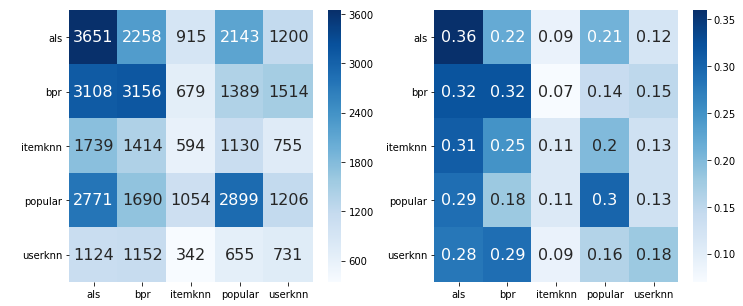

In [18]:
# TEST SET RESULTS
print_metrics(model, test[meta_features], test['class_n'], test[METRICS], mapping, test_all[METRICS], 'whole_set')

In [19]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(meta_features)), meta_features, model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
34,item_appearance_mean,0.028003
33,item_appearance_q3,0.027042
31,item_appearance_q1,0.025389
59,seconds_diff_q3,0.022182
54,seconds_diff_min,0.021896
57,seconds_diff_q1,0.021543
35,item_appearance_min,0.020594
56,seconds_diff_mean,0.020190
36,item_appearance_max,0.020158
32,item_appearance_q2,0.020110


In [20]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/whole_set.csv', index=False)

## 2 Searching for optimal subsets of base level algorithms (classes) and features

In [25]:
best_hparams = {'random_state': [1739],
 'n_estimators': [100],
 'min_samples_split': [30],
 'min_samples_leaf': [5],
 'max_depth': [11],
 'criterion': ['entropy']}

### 2.1 Configuration #1

In [22]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 0.5
BPSO_INERTIA = 0.9
BPSO_NEIGHBORS = 5
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 20
CONFIG_STR = 'config_1'

#### 2.1.1 BPSO

In [23]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-21 15:50:06,730 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.936
2020-05-21 16:26:52,838 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9359806140105477, best pos: [1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1]


CPU times: user 19min 12s, sys: 1.15 s, total: 19min 13s
Wall time: 36min 46s


In [ ]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [24]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
60,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, ...",0.064019,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_10%+, users_sharing_2+, users_s...",3,49,47
133,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...",0.063853,"[als, bpr, popular]","[unique_items, users_sharing_10%+, users_shari...","[users_sharing_1, users_sharing_1+, users_shar...",3,52,44
136,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.063765,"[als, bpr, popular]","[users_sharing_10%+, users_sharing_20%+, users...","[unique_items, users_sharing_1, users_sharing_...",3,52,44
127,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...",0.063736,"[als, bpr, popular]","[users_sharing_10%+, users_sharing_2, users_sh...","[unique_items, users_sharing_1, users_sharing_...",3,55,41
131,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, ...",0.063708,"[als, bpr, popular]","[users_sharing_10%+, users_sharing_2, users_sh...","[unique_items, users_sharing_1, users_sharing_...",3,51,45


In [25]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06401938598945234
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 49
Features excluded: 47


In [26]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['unique_items', 'users_sharing_1', 'users_sharing_1+',
       'users_sharing_2', 'users_sharing_20%+', 'users_sharing_3',
       'users_sharing_30%+', 'users_sharing_5', 'users_sharing_6+',
       'users_sharing_7', 'users_sharing_7+', 'users_sharing_8+',
       'users_sharing_9', 'users_sharing_9+', 'users_sharing_10+',
       'item_appearance_mean', 'item_appearance_max', 'g_depth_3_edges_2',
       'g_depth_2_density_0', 'g_depth_3_vertices', 'g_depth_3_edges_0',
       'g_depth_3_edges_1', 'g_depth_3_possible_edges_0',
       'g_depth_3_density_0', 'g_depth_3_density_2', 'seconds_diff_max',
       'seconds_diff_q1', 'seconds_diff_q2', 'ds_price_min',
       'ds_price_max', 'ds_price_mean', 'ds_price_q1', 'ds_price_q2',
       'ds_price_q3', 'ds_brand_top_count',
       'ds_brand_price_level_top_count_normalized',
       'ds_category_full_nunique', 'ds_category1_top_count_normalized',
       'ds_category2_nunique', 'ds_category2_top_count',
       'ds_category3_top_count_norm

In [27]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['users_sharing_10%+', 'users_sharing_2+', 'users_sharing_3+',
       'users_sharing_4', 'users_sharing_4+', 'users_sharing_40%+',
       'users_sharing_5+', 'users_sharing_50%+', 'users_sharing_6',
       'users_sharing_60%+', 'users_sharing_70%+', 'users_sharing_8',
       'users_sharing_80%+', 'users_sharing_90%+', 'users_sharing_10',
       'users_sharing_100%+', 'item_appearance_q1', 'item_appearance_q2',
       'item_appearance_q3', 'item_appearance_min', 'g_depth_2_edges_1',
       'g_depth_2_vertices', 'g_depth_2_edges_0',
       'g_depth_2_possible_edges_0', 'g_depth_2_possible_edges_1',
       'g_depth_2_density_1', 'g_depth_3_possible_edges_1',
       'g_depth_3_density_1', 'g_depth_3_possible_edges_2',
       'seconds_diff_min', 'seconds_diff_mean', 'seconds_diff_q3',
       'ds_brand_nunique', 'ds_brand_top_count_normalized',
       'ds_brand_price_level_nunique', 'ds_brand_price_level_top_count',
       'ds_category_full_top_count',
       'ds_category_full_top_coun

#### 2.1.2 Hyperparameter tuning for optimal subsets

In [28]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 1min 13s, sys: 984 ms, total: 1min 14s
Wall time: 32min 2s


In [29]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.11992826059378738

In [30]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 850,
 'min_samples_split': 10,
 'min_samples_leaf': 15,
 'max_depth': 11,
 'criterion': 'gini'}

accuracy:  0.4307863884884259

              precision    recall  f1-score   support

           0       0.37      0.43      0.40     11907
           1       0.51      0.47      0.49     14318
           2       0.41      0.39      0.40     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.43      0.43     36763
weighted avg       0.44      0.43      0.43     36763

macro precision:  0.4299698029457178
micro precision:  0.4307863884884259

micro recall:  0.4307863884884259
macro recall:  0.42668371690150136

micro f1:  0.4307863884884259
macro f1:  0.427204122760057
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (all alg

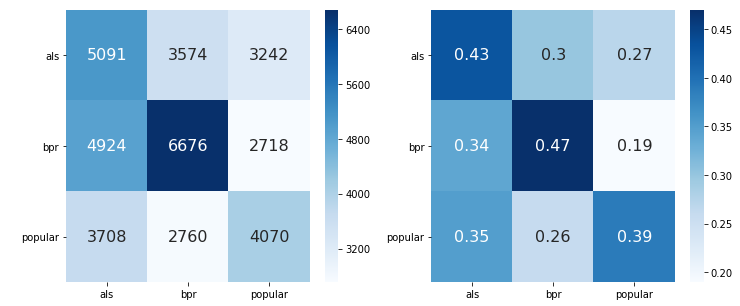

In [31]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [32]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
15,item_appearance_mean,0.071302
16,item_appearance_max,0.049244
26,seconds_diff_q1,0.035949
18,g_depth_2_density_0,0.035157
4,users_sharing_20%+,0.033156
3,users_sharing_2,0.032943
27,seconds_diff_q2,0.032824
25,seconds_diff_max,0.032758
23,g_depth_3_density_0,0.032068
24,g_depth_3_density_2,0.031247


In [33]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.2 Configuration #2

In [34]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 0.5
BPSO_INERTIA = 0.3
BPSO_NEIGHBORS = 5
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 20
CONFIG_STR = 'config_2'

#### 2.2.1 BPSO

In [35]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-21 18:14:07,746 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.3, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.937
2020-05-21 18:48:15,115 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9366272174463653, best pos: [1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0
 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0]


CPU times: user 17min 46s, sys: 1.36 s, total: 17min 47s
Wall time: 34min 7s


In [ ]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [36]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
102,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...",0.063373,"[als, bpr, itemknn, popular]","[users_sharing_2, users_sharing_2+, users_shar...","[unique_items, users_sharing_1, users_sharing_...",4,48,48
62,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...",0.063173,"[als, bpr, itemknn, popular]","[users_sharing_1+, users_sharing_10%+, users_s...","[unique_items, users_sharing_1, users_sharing_...",4,48,48
60,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.062884,"[als, bpr, itemknn, popular]","[users_sharing_10%+, users_sharing_20%+, users...","[unique_items, users_sharing_1, users_sharing_...",4,49,47
58,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.062865,"[als, bpr, itemknn, popular]","[users_sharing_10%+, users_sharing_20%+, users...","[unique_items, users_sharing_1, users_sharing_...",4,49,47
109,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",0.062851,"[als, bpr, itemknn, popular]","[users_sharing_2, users_sharing_2+, users_shar...","[unique_items, users_sharing_1, users_sharing_...",4,47,49


In [37]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06337278255363465
Algorithms subset: ['als' 'bpr' 'itemknn' 'popular']
Features used: 48
Features excluded: 48


In [38]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['users_sharing_2', 'users_sharing_2+', 'users_sharing_20%+',
       'users_sharing_3', 'users_sharing_30%+', 'users_sharing_4',
       'users_sharing_40%+', 'users_sharing_5', 'users_sharing_5+',
       'users_sharing_50%+', 'users_sharing_6', 'users_sharing_6+',
       'users_sharing_7+', 'users_sharing_8+', 'users_sharing_80%+',
       'users_sharing_9', 'users_sharing_9+', 'users_sharing_100%+',
       'item_appearance_q3', 'item_appearance_min', 'item_appearance_max',
       'g_depth_2_edges_0', 'g_depth_2_possible_edges_1',
       'g_depth_3_vertices', 'g_depth_3_edges_0', 'g_depth_3_density_0',
       'g_depth_3_possible_edges_1', 'g_depth_3_density_1',
       'g_depth_3_density_2', 'seconds_diff_min', 'seconds_diff_max',
       'seconds_diff_q2', 'seconds_diff_q3', 'ds_price_min',
       'ds_price_max', 'ds_price_q2', 'ds_brand_nunique',
       'ds_brand_price_level_nunique',
       'ds_brand_price_level_top_count_normalized',
       'ds_category_full_nunique', 'ds_catego

In [39]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['unique_items', 'users_sharing_1', 'users_sharing_1+',
       'users_sharing_10%+', 'users_sharing_3+', 'users_sharing_4+',
       'users_sharing_60%+', 'users_sharing_7', 'users_sharing_70%+',
       'users_sharing_8', 'users_sharing_90%+', 'users_sharing_10',
       'users_sharing_10+', 'item_appearance_q1', 'item_appearance_q2',
       'item_appearance_mean', 'g_depth_2_edges_1', 'g_depth_3_edges_2',
       'g_depth_2_vertices', 'g_depth_2_possible_edges_0',
       'g_depth_2_density_0', 'g_depth_2_density_1', 'g_depth_3_edges_1',
       'g_depth_3_possible_edges_0', 'g_depth_3_possible_edges_2',
       'seconds_diff_mean', 'seconds_diff_q1', 'ds_price_mean',
       'ds_price_q1', 'ds_price_q3', 'ds_brand_top_count',
       'ds_brand_top_count_normalized', 'ds_brand_price_level_top_count',
       'ds_category_full_top_count_normalized', 'ds_category1_nunique',
       'ds_category1_top_count_normalized', 'ds_category2_nunique',
       'ds_category2_top_count', 'ds_category3_nu

#### 2.2.2 Hyperparameter tuning for optimal subsets

In [40]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 56.6 s, sys: 1.02 s, total: 57.6 s
Wall time: 31min 12s


In [41]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.11577296221335748

In [42]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

accuracy:  0.34822695035460993

              precision    recall  f1-score   support

           0       0.33      0.41      0.36     10870
           1       0.38      0.43      0.41     10828
           2       0.20      0.09      0.12      6239
           3       0.38      0.35      0.36     10133

   micro avg       0.35      0.35      0.35     38070
   macro avg       0.32      0.32      0.31     38070
weighted avg       0.34      0.35      0.34     38070

macro precision:  0.3217492079177958
micro precision:  0.34822695035460993

micro recall:  0.34822695035460993
macro recall:  0.3207533750608219

micro f1:  0.34822695035460993
macro f1:  0.3143393469973544
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11794030951436854

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0

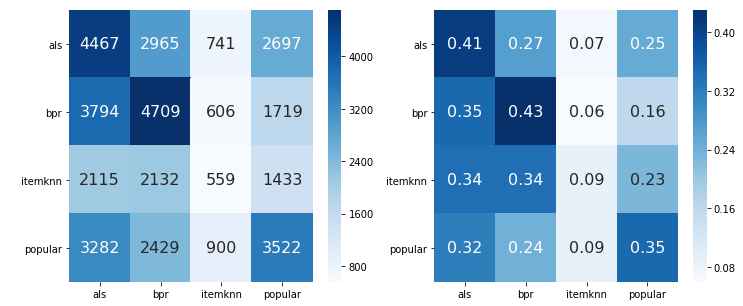

In [43]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [44]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
18,item_appearance_q3,0.081439
19,item_appearance_min,0.044682
2,users_sharing_20%+,0.043679
4,users_sharing_30%+,0.041615
20,item_appearance_max,0.039955
29,seconds_diff_min,0.036855
24,g_depth_3_edges_0,0.035248
9,users_sharing_50%+,0.032941
6,users_sharing_40%+,0.032096
23,g_depth_3_vertices,0.030638


In [45]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.3 Configuration #3

In [46]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 1
BPSO_INERTIA = 0.3
BPSO_NEIGHBORS = 5
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 20
CONFIG_STR = 'config_3'

#### 2.3.1 BPSO

In [47]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-21 19:20:00,584 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 1, 'w': 0.3, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.936
2020-05-21 19:57:50,036 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9357969521936941, best pos: [1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1
 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0
 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0]


CPU times: user 19min 50s, sys: 1.41 s, total: 19min 52s
Wall time: 37min 49s


In [ ]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [48]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
169,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...",0.064203,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_10%+, users_sh...",3,47,49
162,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...",0.063973,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_10%+, users_sh...",3,45,51
123,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0.063957,"[als, bpr, itemknn, popular]","[users_sharing_1, users_sharing_10%+, users_sh...","[unique_items, users_sharing_1+, users_sharing...",4,55,41
163,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...",0.063781,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_10%+, users_sh...",3,47,49
68,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",0.063725,"[als, bpr, popular]","[users_sharing_1+, users_sharing_10%+, users_s...","[unique_items, users_sharing_1, users_sharing_...",3,53,43


In [49]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06420304780630592
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 47
Features excluded: 49


In [50]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['unique_items', 'users_sharing_1+', 'users_sharing_20%+',
       'users_sharing_3', 'users_sharing_3+', 'users_sharing_40%+',
       'users_sharing_5', 'users_sharing_50%+', 'users_sharing_6',
       'users_sharing_60%+', 'users_sharing_7+', 'users_sharing_8',
       'users_sharing_8+', 'users_sharing_10', 'users_sharing_10+',
       'item_appearance_q1', 'item_appearance_q3', 'item_appearance_mean',
       'item_appearance_min', 'item_appearance_max', 'g_depth_2_edges_1',
       'g_depth_2_vertices', 'g_depth_2_edges_0', 'g_depth_2_density_0',
       'g_depth_3_vertices', 'g_depth_3_edges_0', 'g_depth_3_edges_1',
       'g_depth_3_density_0', 'g_depth_3_possible_edges_1',
       'g_depth_3_possible_edges_2', 'seconds_diff_min',
       'seconds_diff_mean', 'seconds_diff_q3', 'ds_brand_nunique',
       'ds_brand_top_count', 'ds_brand_price_level_top_count',
       'ds_category_full_nunique',
       'ds_category_full_top_count_normalized', 'ds_category1_nunique',
       'ds_catego

In [51]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['users_sharing_1', 'users_sharing_10%+', 'users_sharing_2',
       'users_sharing_2+', 'users_sharing_30%+', 'users_sharing_4',
       'users_sharing_4+', 'users_sharing_5+', 'users_sharing_6+',
       'users_sharing_7', 'users_sharing_70%+', 'users_sharing_80%+',
       'users_sharing_9', 'users_sharing_9+', 'users_sharing_90%+',
       'users_sharing_100%+', 'item_appearance_q2', 'g_depth_3_edges_2',
       'g_depth_2_possible_edges_0', 'g_depth_2_possible_edges_1',
       'g_depth_2_density_1', 'g_depth_3_possible_edges_0',
       'g_depth_3_density_1', 'g_depth_3_density_2', 'seconds_diff_max',
       'seconds_diff_q1', 'seconds_diff_q2', 'ds_price_min',
       'ds_price_max', 'ds_price_mean', 'ds_price_q1', 'ds_price_q2',
       'ds_price_q3', 'ds_brand_top_count_normalized',
       'ds_brand_price_level_nunique',
       'ds_brand_price_level_top_count_normalized',
       'ds_category_full_top_count', 'ds_category1_top_count',
       'ds_category2_nunique', 'ds_category2_to

#### 2.3.2 Hyperparameter tuning for optimal subsets

In [52]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 1min 8s, sys: 1.1 s, total: 1min 9s
Wall time: 28min 13s


In [53]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.1203511316920571

In [54]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 650,
 'min_samples_split': 15,
 'min_samples_leaf': 15,
 'max_depth': 25,
 'criterion': 'gini'}

accuracy:  0.428909501400865

              precision    recall  f1-score   support

           0       0.37      0.41      0.39     11907
           1       0.50      0.48      0.49     14318
           2       0.41      0.38      0.39     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.42      0.42     36763
weighted avg       0.43      0.43      0.43     36763

macro precision:  0.425854296182864
micro precision:  0.428909501400865

micro recall:  0.428909501400865
macro recall:  0.42341327858510275

micro f1:  0.4289095014008649
macro f1:  0.424100538912447
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (all alg.): 

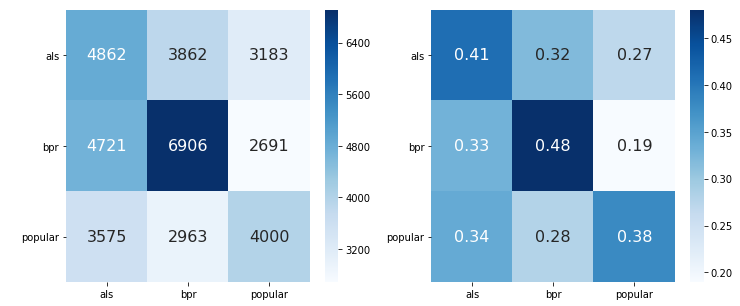

In [55]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [56]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
17,item_appearance_mean,0.057787
16,item_appearance_q3,0.057190
30,seconds_diff_min,0.044834
15,item_appearance_q1,0.043538
19,item_appearance_max,0.040599
31,seconds_diff_mean,0.039389
32,seconds_diff_q3,0.037041
27,g_depth_3_density_0,0.035910
18,item_appearance_min,0.033622
24,g_depth_3_vertices,0.032082


In [57]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.4 Configuration #4

In [34]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 1
BPSO_INERTIA = 0.9
BPSO_NEIGHBORS = 5
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 20
CONFIG_STR = 'config_4'

#### 2.4.1 BPSO

In [35]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-22 07:08:41,554 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 1, 'w': 0.9, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.936
2020-05-22 07:50:11,072 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9360585251373013, best pos: [1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0
 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1]


CPU times: user 22min 9s, sys: 1.66 s, total: 22min 11s
Wall time: 41min 29s


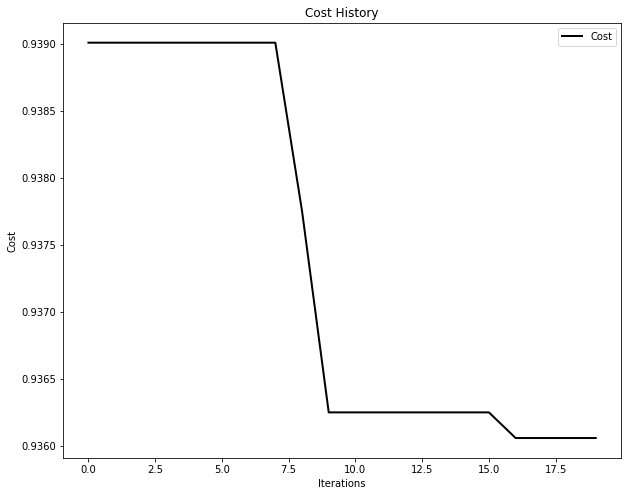

In [36]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [38]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
148,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, ...",0.063941,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_2, users_sharing_20%+, users_sh...",3,51,45
147,"[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.063931,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_10%+, users_shari...",3,48,48
152,"[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ...",0.063885,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_10%+, users_shari...",3,53,43
155,"[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...",0.063866,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_10%+, users_shari...",3,53,43
91,"[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...",0.063750,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_20%+, users_shari...",3,51,45


In [39]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06394147486269874
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 51
Features excluded: 45


In [40]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['unique_items', 'users_sharing_1', 'users_sharing_1+',
       'users_sharing_10%+', 'users_sharing_2+', 'users_sharing_3',
       'users_sharing_30%+', 'users_sharing_5+', 'users_sharing_6',
       'users_sharing_7', 'users_sharing_70%+', 'users_sharing_80%+',
       'users_sharing_9', 'users_sharing_9+', 'users_sharing_10+',
       'users_sharing_100%+', 'item_appearance_q2', 'item_appearance_q3',
       'item_appearance_mean', 'g_depth_2_edges_1', 'g_depth_3_edges_2',
       'g_depth_2_edges_0', 'g_depth_2_density_0', 'g_depth_3_vertices',
       'g_depth_3_possible_edges_0', 'g_depth_3_density_1',
       'g_depth_3_density_2', 'seconds_diff_min', 'seconds_diff_max',
       'seconds_diff_q1', 'ds_price_max', 'ds_price_mean', 'ds_price_q1',
       'ds_price_q2', 'ds_price_q3', 'ds_brand_nunique',
       'ds_brand_top_count', 'ds_brand_price_level_nunique',
       'ds_category_full_top_count_normalized', 'ds_category1_nunique',
       'ds_category1_top_count', 'ds_category2_nuni

In [41]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['users_sharing_2', 'users_sharing_20%+', 'users_sharing_3+',
       'users_sharing_4', 'users_sharing_4+', 'users_sharing_40%+',
       'users_sharing_5', 'users_sharing_50%+', 'users_sharing_6+',
       'users_sharing_60%+', 'users_sharing_7+', 'users_sharing_8',
       'users_sharing_8+', 'users_sharing_90%+', 'users_sharing_10',
       'item_appearance_q1', 'item_appearance_min', 'item_appearance_max',
       'g_depth_2_vertices', 'g_depth_2_possible_edges_0',
       'g_depth_2_possible_edges_1', 'g_depth_2_density_1',
       'g_depth_3_edges_0', 'g_depth_3_edges_1', 'g_depth_3_density_0',
       'g_depth_3_possible_edges_1', 'g_depth_3_possible_edges_2',
       'seconds_diff_mean', 'seconds_diff_q2', 'seconds_diff_q3',
       'ds_price_min', 'ds_brand_top_count_normalized',
       'ds_brand_price_level_top_count',
       'ds_brand_price_level_top_count_normalized',
       'ds_category_full_nunique', 'ds_category_full_top_count',
       'ds_category1_top_count_normalized', 'd

#### 2.4.2 Hyperparameter tuning for optimal subsets

In [42]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 1min 16s, sys: 1.17 s, total: 1min 17s
Wall time: 32min 16s


In [43]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.12052369496621403

In [44]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 450,
 'min_samples_split': 50,
 'min_samples_leaf': 5,
 'max_depth': 11,
 'criterion': 'entropy'}

accuracy:  0.43048717460490166

              precision    recall  f1-score   support

           0       0.37      0.44      0.40     11907
           1       0.51      0.46      0.49     14318
           2       0.41      0.38      0.39     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.43      0.43     36763
weighted avg       0.44      0.43      0.43     36763

macro precision:  0.4301457718478247
micro precision:  0.43048717460490166

micro recall:  0.43048717460490166
macro recall:  0.42646411531249234

micro f1:  0.43048717460490166
macro f1:  0.42693827191645733
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (a

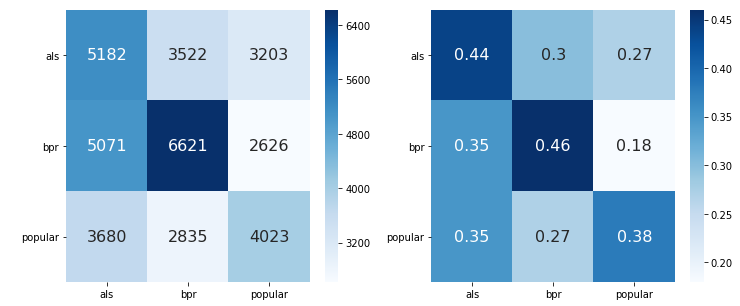

In [45]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [46]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
18,item_appearance_mean,0.064840
17,item_appearance_q3,0.060818
16,item_appearance_q2,0.050074
27,seconds_diff_min,0.038874
29,seconds_diff_q1,0.035594
28,seconds_diff_max,0.034601
20,g_depth_3_edges_2,0.031383
23,g_depth_3_vertices,0.028586
1,users_sharing_1,0.028102
3,users_sharing_10%+,0.028005


In [47]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.5 Configuration #5

In [48]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 0.5
BPSO_INERTIA = 0.9
BPSO_NEIGHBORS = 10
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 20
CONFIG_STR = 'config_5'

#### 2.5.1 BPSO

In [49]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-22 08:35:47,268 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.936
2020-05-22 09:19:15,142 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9357275249259531, best pos: [1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1
 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0]


CPU times: user 23min 10s, sys: 1.75 s, total: 23min 11s
Wall time: 43min 27s


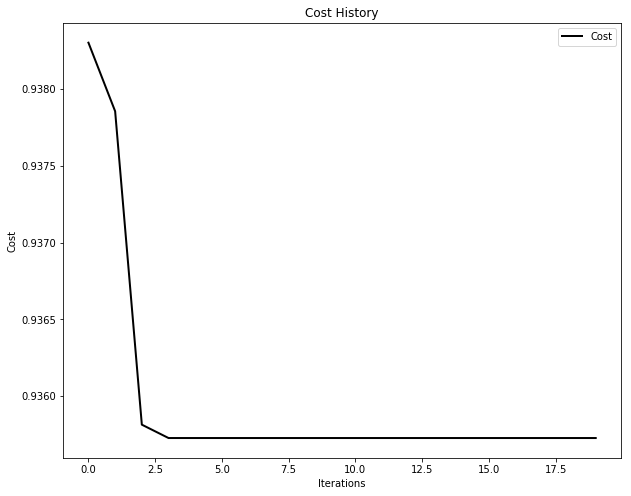

In [50]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [51]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
33,"[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, ...",0.064272,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_3, users_shari...",3,56,40
38,"[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...",0.064243,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_3, users_shari...",3,60,36
29,"[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, ...",0.064185,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_1+, users_sharing_10%+, users_s...",3,56,40
24,"[1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, ...",0.064144,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_1+, users_sharing_2, users_shar...",3,54,42
36,"[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...",0.063915,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_3, users_shari...",3,60,36


In [52]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06427247507404688
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 56
Features excluded: 40


In [53]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['unique_items', 'users_sharing_1+', 'users_sharing_10%+',
       'users_sharing_2', 'users_sharing_2+', 'users_sharing_20%+',
       'users_sharing_3+', 'users_sharing_4', 'users_sharing_4+',
       'users_sharing_40%+', 'users_sharing_5', 'users_sharing_50%+',
       'users_sharing_6', 'users_sharing_6+', 'users_sharing_60%+',
       'users_sharing_7', 'users_sharing_7+', 'users_sharing_8',
       'users_sharing_8+', 'users_sharing_80%+', 'users_sharing_9+',
       'users_sharing_90%+', 'users_sharing_10', 'users_sharing_10+',
       'item_appearance_q1', 'item_appearance_mean',
       'item_appearance_min', 'g_depth_2_edges_1',
       'g_depth_2_possible_edges_0', 'g_depth_2_density_1',
       'g_depth_3_vertices', 'g_depth_3_edges_0',
       'g_depth_3_possible_edges_0', 'g_depth_3_density_0',
       'g_depth_3_density_2', 'seconds_diff_max', 'seconds_diff_q1',
       'seconds_diff_q3', 'ds_price_max', 'ds_price_mean', 'ds_price_q3',
       'ds_brand_nunique', 'ds_brand_top_c

In [54]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['users_sharing_1', 'users_sharing_3', 'users_sharing_30%+',
       'users_sharing_5+', 'users_sharing_70%+', 'users_sharing_9',
       'users_sharing_100%+', 'item_appearance_q2', 'item_appearance_q3',
       'item_appearance_max', 'g_depth_3_edges_2', 'g_depth_2_vertices',
       'g_depth_2_edges_0', 'g_depth_2_density_0',
       'g_depth_2_possible_edges_1', 'g_depth_3_edges_1',
       'g_depth_3_possible_edges_1', 'g_depth_3_density_1',
       'g_depth_3_possible_edges_2', 'seconds_diff_min',
       'seconds_diff_mean', 'seconds_diff_q2', 'ds_price_min',
       'ds_price_q1', 'ds_price_q2', 'ds_brand_price_level_nunique',
       'ds_brand_price_level_top_count', 'ds_category_full_nunique',
       'ds_category_full_top_count', 'ds_category1_nunique',
       'ds_category1_top_count_normalized', 'ds_category2_nunique',
       'ds_category3_nunique', 'ds_category_last_nunique',
       'ds_category_last_top_count',
       'ds_category_last_top_count_normalized', 'ds_gender_top_cou

#### 2.5.2 Hyperparameter tuning for optimal subsets

In [55]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 1min 15s, sys: 924 ms, total: 1min 16s
Wall time: 29min 58s


In [56]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.12077217075157187

In [57]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 500,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_depth': 9,
 'criterion': 'entropy'}

accuracy:  0.42991594809999184

              precision    recall  f1-score   support

           0       0.37      0.44      0.40     11907
           1       0.51      0.46      0.48     14318
           2       0.41      0.38      0.39     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.43      0.43     36763
weighted avg       0.44      0.43      0.43     36763

macro precision:  0.42986075732201146
micro precision:  0.42991594809999184

micro recall:  0.42991594809999184
macro recall:  0.42592282233451556

micro f1:  0.42991594809999184
macro f1:  0.42639856532679543
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (

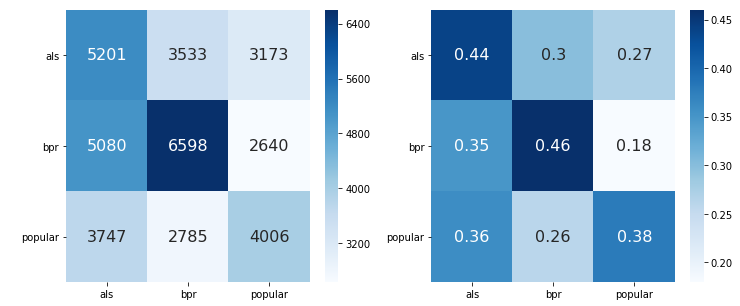

In [58]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [59]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
25,item_appearance_mean,0.071216
24,item_appearance_q1,0.047846
36,seconds_diff_q1,0.035793
31,g_depth_3_edges_0,0.034702
33,g_depth_3_density_0,0.032292
26,item_appearance_min,0.032121
35,seconds_diff_max,0.031475
30,g_depth_3_vertices,0.031134
32,g_depth_3_possible_edges_0,0.031091
34,g_depth_3_density_2,0.030825


In [60]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.6 Configuration #6

In [61]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 0.5
BPSO_INERTIA = 0.9
BPSO_NEIGHBORS = 10
BPSO_PARTICLES = 20
BPSO_ITERATIONS = 30
CONFIG_STR = 'config_6'

#### 2.6.1 BPSO

In [62]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-22 09:55:08,626 - pyswarms.discrete.binary - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|30/30, best_cost=0.935
2020-05-22 11:58:58,843 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9352517192047002, best pos: [1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0
 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0
 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1]


CPU times: user 1h 6min 20s, sys: 4.66 s, total: 1h 6min 24s
Wall time: 2h 3min 50s


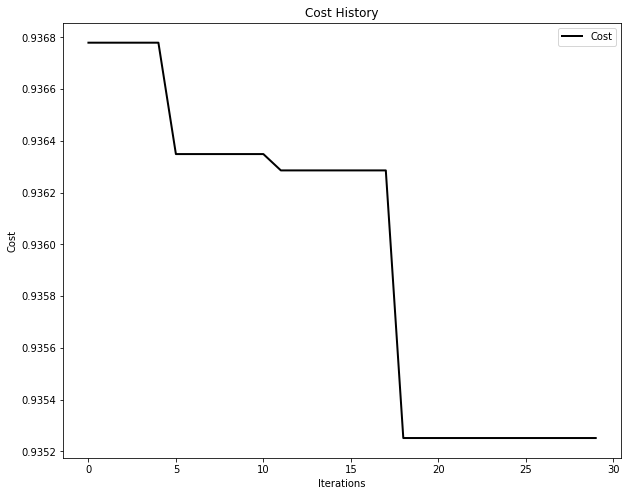

In [63]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [64]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
348,"[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...",0.064748,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_2+, users_shar...",3,51,45
510,"[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",0.064742,"[als, bpr, popular]","[users_sharing_1, users_sharing_2, users_shari...","[unique_items, users_sharing_1+, users_sharing...",3,41,55
334,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",0.064272,"[als, bpr, popular]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_10%+, users_sh...",3,49,47
331,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...",0.064268,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_10%+, users_sharing_2+, users_s...",3,44,52
338,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.064258,"[als, bpr, popular]","[unique_items, users_sharing_1, users_sharing_...","[users_sharing_30%+, users_sharing_4+, users_s...",3,56,40


In [65]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.06474828079529982
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 51
Features excluded: 45


In [66]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['unique_items', 'users_sharing_1+', 'users_sharing_10%+',
       'users_sharing_2', 'users_sharing_3', 'users_sharing_3+',
       'users_sharing_4', 'users_sharing_5', 'users_sharing_7',
       'users_sharing_7+', 'users_sharing_9', 'users_sharing_90%+',
       'users_sharing_100%+', 'item_appearance_q2', 'item_appearance_q3',
       'g_depth_3_edges_2', 'g_depth_2_vertices', 'g_depth_2_edges_0',
       'g_depth_2_possible_edges_0', 'g_depth_2_possible_edges_1',
       'g_depth_2_density_1', 'g_depth_3_vertices', 'g_depth_3_edges_0',
       'g_depth_3_edges_1', 'g_depth_3_possible_edges_1',
       'g_depth_3_possible_edges_2', 'g_depth_3_density_2',
       'seconds_diff_min', 'seconds_diff_max', 'seconds_diff_q2',
       'seconds_diff_q3', 'ds_price_min', 'ds_price_max', 'ds_price_q1',
       'ds_brand_nunique', 'ds_brand_price_level_top_count_normalized',
       'ds_category_full_nunique', 'ds_category_full_top_count',
       'ds_category_full_top_count_normalized', 'ds_categor

In [67]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['users_sharing_1', 'users_sharing_2+', 'users_sharing_20%+',
       'users_sharing_30%+', 'users_sharing_4+', 'users_sharing_40%+',
       'users_sharing_5+', 'users_sharing_50%+', 'users_sharing_6',
       'users_sharing_6+', 'users_sharing_60%+', 'users_sharing_70%+',
       'users_sharing_8', 'users_sharing_8+', 'users_sharing_80%+',
       'users_sharing_9+', 'users_sharing_10', 'users_sharing_10+',
       'item_appearance_q1', 'item_appearance_mean',
       'item_appearance_min', 'item_appearance_max', 'g_depth_2_edges_1',
       'g_depth_2_density_0', 'g_depth_3_possible_edges_0',
       'g_depth_3_density_0', 'g_depth_3_density_1', 'seconds_diff_mean',
       'seconds_diff_q1', 'ds_price_mean', 'ds_price_q2', 'ds_price_q3',
       'ds_brand_top_count', 'ds_brand_top_count_normalized',
       'ds_brand_price_level_nunique', 'ds_brand_price_level_top_count',
       'ds_category1_top_count', 'ds_category2_nunique',
       'ds_category2_top_count', 'ds_category2_top_count_nor

#### 2.6.2 Hyperparameter tuning for optimal subsets

In [68]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 57.9 s, sys: 952 ms, total: 58.9 s
Wall time: 33min 37s


In [69]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.12127123270276799

In [70]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 100,
 'min_samples_split': 30,
 'min_samples_leaf': 5,
 'max_depth': 11,
 'criterion': 'entropy'}

accuracy:  0.4268150042161956

              precision    recall  f1-score   support

           0       0.37      0.44      0.40     11907
           1       0.51      0.46      0.48     14318
           2       0.40      0.37      0.38     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.42      0.42     36763
weighted avg       0.43      0.43      0.43     36763

macro precision:  0.4263842647745311
micro precision:  0.4268150042161956

micro recall:  0.4268150042161956
macro recall:  0.4223603283537243

micro f1:  0.4268150042161956
macro f1:  0.42277419288801005
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (all al

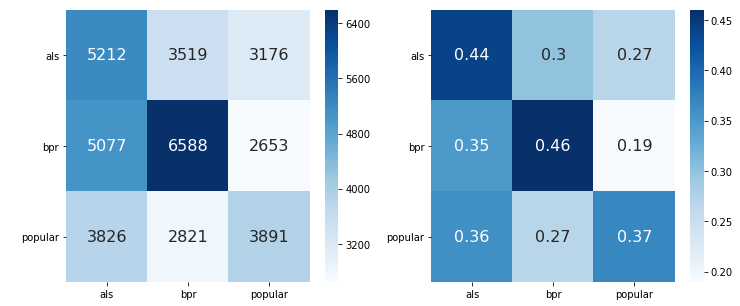

In [71]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [72]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
14,item_appearance_q3,0.062962
13,item_appearance_q2,0.057214
27,seconds_diff_min,0.039978
28,seconds_diff_max,0.034538
20,g_depth_2_density_1,0.031039
26,g_depth_3_density_2,0.030942
2,users_sharing_10%+,0.030567
33,ds_price_q1,0.030099
29,seconds_diff_q2,0.029609
22,g_depth_3_edges_0,0.029361


In [73]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)

### 2.7 Configuration #7 - cross-validation replaced by random search with cross-validation

In [26]:
BPSO_COGNITIVE = 0.5
BPSO_SOCIAL = 0.5
BPSO_INERTIA = 0.9
BPSO_NEIGHBORS = 5
BPSO_PARTICLES = 10
BPSO_ITERATIONS = 10
CONFIG_STR = 'config_7'

#### 2.7.1 BPSO

In [27]:
%%time

def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    params = {
        'n_estimators': list(range(50, 550, 50)),
        'criterion': ['gini', 'entropy'],
        'max_depth': list(range(5, 20)),
        'min_samples_split': list(range(5, 55, 5)),
        'min_samples_leaf': list(range(5, 35, 5)),
        'random_state': [RAND_STATE]
    }
    rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=20, random_state=RAND_STATE, error_score=0)
    rs.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    model = rs.best_estimator_
    
    # score calculation is based on all users in train set
    #
    # rs.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(rs.best_score_ * len(train) / len(train_all))
    return 1 - (rs.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])


options = {'c1': BPSO_COGNITIVE,
           'c2': BPSO_SOCIAL,
           'w': BPSO_INERTIA,
           'k': BPSO_NEIGHBORS,
           'p': 2 } # use euclidian distance
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=BPSO_PARTICLES, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=BPSO_ITERATIONS)

2020-05-22 15:50:10,404 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.936
2020-05-22 19:39:34,322 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.935821886384266, best pos: [1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0]


CPU times: user 24min 49s, sys: 11.1 s, total: 25min
Wall time: 3h 49min 23s


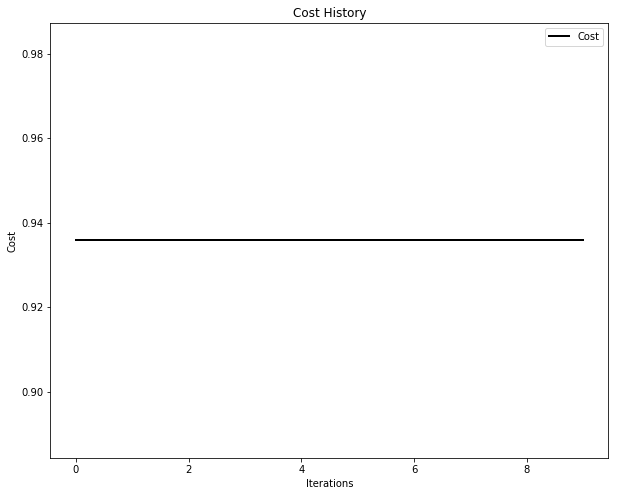

In [28]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [29]:
particles_performance = pd.DataFrame(particles_performance)
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
3,"[1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...",0.064178,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_10%+, users_shari...",3,42,54
46,"[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",0.064130,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_2, users_sharing_...",3,52,44
47,"[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",0.064080,"[als, bpr, popular]","[users_sharing_1, users_sharing_1+, users_shar...","[unique_items, users_sharing_2, users_sharing_...",3,50,46
44,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...",0.064077,"[als, bpr, popular]","[users_sharing_10%+, users_sharing_20%+, users...","[unique_items, users_sharing_1, users_sharing_...",3,47,49
43,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...",0.064041,"[als, bpr, popular]","[users_sharing_1+, users_sharing_20%+, users_s...","[unique_items, users_sharing_1, users_sharing_...",3,44,52


In [30]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))
particles_performance.to_csv(DATA_PATH+'meta/bpso_progress/' + CONFIG_STR + '.csv', index=False)

Best model NDCG: 0.064178113615734
Algorithms subset: ['als' 'bpr' 'popular']
Features used: 42
Features excluded: 54


In [31]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['users_sharing_1', 'users_sharing_1+', 'users_sharing_2',
       'users_sharing_2+', 'users_sharing_3', 'users_sharing_4+',
       'users_sharing_6+', 'users_sharing_60%+', 'users_sharing_7',
       'users_sharing_7+', 'users_sharing_8', 'users_sharing_9+',
       'users_sharing_90%+', 'users_sharing_10', 'users_sharing_10+',
       'users_sharing_100%+', 'item_appearance_q1', 'item_appearance_q2',
       'item_appearance_q3', 'item_appearance_mean', 'g_depth_3_edges_2',
       'g_depth_2_vertices', 'g_depth_2_possible_edges_0',
       'g_depth_3_vertices', 'g_depth_3_possible_edges_2',
       'g_depth_3_density_2', 'seconds_diff_mean', 'seconds_diff_q1',
       'seconds_diff_q2', 'ds_price_min', 'ds_brand_nunique',
       'ds_brand_price_level_nunique', 'ds_category_full_top_count',
       'ds_category_full_top_count_normalized',
       'ds_category1_top_count_normalized',
       'ds_category2_top_count_normalized', 'ds_category3_nunique',
       'ds_category3_top_count_normali

In [32]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['unique_items', 'users_sharing_10%+', 'users_sharing_20%+',
       'users_sharing_3+', 'users_sharing_30%+', 'users_sharing_4',
       'users_sharing_40%+', 'users_sharing_5', 'users_sharing_5+',
       'users_sharing_50%+', 'users_sharing_6', 'users_sharing_70%+',
       'users_sharing_8+', 'users_sharing_80%+', 'users_sharing_9',
       'item_appearance_min', 'item_appearance_max', 'g_depth_2_edges_1',
       'g_depth_2_edges_0', 'g_depth_2_density_0',
       'g_depth_2_possible_edges_1', 'g_depth_2_density_1',
       'g_depth_3_edges_0', 'g_depth_3_edges_1',
       'g_depth_3_possible_edges_0', 'g_depth_3_density_0',
       'g_depth_3_possible_edges_1', 'g_depth_3_density_1',
       'seconds_diff_min', 'seconds_diff_max', 'seconds_diff_q3',
       'ds_price_max', 'ds_price_mean', 'ds_price_q1', 'ds_price_q2',
       'ds_price_q3', 'ds_brand_top_count',
       'ds_brand_top_count_normalized', 'ds_brand_price_level_top_count',
       'ds_brand_price_level_top_count_normalized',

#### 2.7.2 Hyperparameter tuning for optimal subsets

In [33]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 54.6 s, sys: 840 ms, total: 55.5 s
Wall time: 26min 45s


In [34]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.12060319666251287

In [35]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 350,
 'min_samples_split': 35,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

accuracy:  0.4300247531485461

              precision    recall  f1-score   support

           0       0.37      0.45      0.41     11907
           1       0.51      0.45      0.48     14318
           2       0.41      0.38      0.40     10538

   micro avg       0.43      0.43      0.43     36763
   macro avg       0.43      0.43      0.43     36763
weighted avg       0.44      0.43      0.43     36763

macro precision:  0.4316721935525795
micro precision:  0.4300247531485461

micro recall:  0.4300247531485461
macro recall:  0.4271774914627704

micro f1:  0.4300247531485461
macro f1:  0.4272437550620875
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.11027076362497976

Base level - best single algorithm (alg. subset):  0.05629286576279236
Base level - best single algorithm (all alg.):  0.056292865762792355

Possible absolute improvement (alg. subset):  0.053977897862187395
Possible absolute improvement (all alg

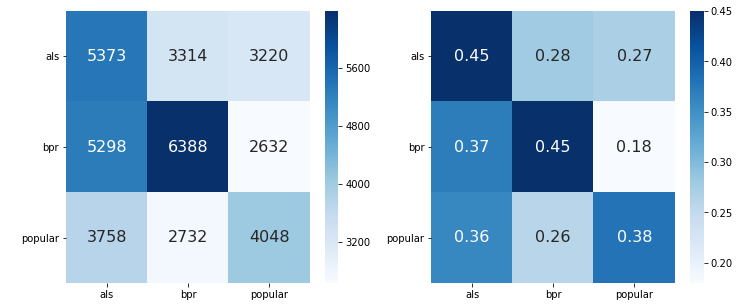

In [36]:
# TEST SET RESULTS - #best
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS], CONFIG_STR)

In [37]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(np.array(meta_features)[pos[5:] == 1])),
                               np.array(meta_features)[pos[5:] == 1],
                               model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
19,item_appearance_mean,0.104208
18,item_appearance_q3,0.091861
17,item_appearance_q2,0.067292
16,item_appearance_q1,0.055352
20,g_depth_3_edges_2,0.036727
0,users_sharing_1,0.036385
27,seconds_diff_q1,0.033130
21,g_depth_2_vertices,0.032749
26,seconds_diff_mean,0.032556
2,users_sharing_2,0.032250


In [38]:
importances.sort_values(by='importance', ascending=False).to_csv(DATA_PATH+'meta/feature_importance/' + CONFIG_STR + '.csv', index=False)